_Version log: Branch of V19. Parameter scan accross number of pixels._

In [6]:
import sys, warnings, time
import numpy as np
import CS_functions as cs
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
from matplotlib import ticker as ticker, pyplot as plt, lines as mpllines
from scipy import fft as spfft, interpolate as spinter
from scipy.constants import c as C
from tqdm import tqdm
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':28, 'lines.markersize': 8.0, 'lines.linewidth': 2.4, 'lines.markersize': 10.0, 'lines.markeredgewidth': 2.4,
                     'figure.facecolor': 'none', 'axes.facecolor': 'white',
                     "xtick.minor.visible": True, "ytick.minor.visible": True, 'xtick.direction': 'in', 'ytick.direction': 'in'})
#np.set_printoptions(threshold=sys.maxsize)

In [7]:
def interpolate(y, new_number_of_points):
    x = range(len(y))
    new_x = np.linspace(0, len(y) -1, new_number_of_points, endpoint= True)
    inter = spinter.interp1d(x, y, kind= "linear", bounds_error= False, fill_value= "extrapolate")
    return inter(new_x)

## TRAIN WITH NOISELESS INTERFEROGRAM

In [8]:
training_file_number = 32 # Use a noiseless version of the interferogram for good convergence
training_file_name = "1dmockanderrors{:d}".format(training_file_number)
#training_file_name = "240802134128_altered1d"

file_type = ".csv"
regularization_coeffient = 1e-2 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)

In [9]:
#LOOP INITIALISATION

unique_reduced_points = [3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,35,40,45,50]
repetitions = 5
reduced_points = np.repeat(unique_reduced_points, repetitions)

training_target, training_uncertainties = cs.open_dataset(training_file_name, file_type)
training_uncertainties /= np.max(training_target)
training_target /= np.max(training_target) #normalise
training_peak = np.argmax(training_target)
total_point = len(training_target)

optlocs_file = "data\\" + training_file_name +"_optlocs.csv"

best_scores = {"Uniform sampling": np.array([]),
               "Douglas-Peucker": np.array([]),
               "Greedy": np.array([]),
               "Metropolis": np.array([]),
               "Simulated annealing": np.array([])}
configurations = {"Uniform sampling": [],
                  "Douglas-Peucker": [],
                  "Greedy": [],
                  "Metropolis": [],
                  "Simulated annealing": []}
runtimes = {"Uniform sampling": np.array([]),
            "Douglas-Peucker": np.array([]),
            "Greedy": np.array([]),
            "Metropolis": np.array([]),
            "Simulated annealing": np.array([])}

runtimes["Brute force"] = np.array([0.03,
                                    0.8,
                                    14,
                                    185,
                                    2100,
                                    13000,
                                    67000,
                                    350000,
                                    810,
                                    0.001])
configurations["Brute force"] = [[47],
                                 [23,25],
                                 [17,23,25],
                                 [23,25,27,33],
                                 [21,23,25,27,28],
                                 [19,23,25,27,30,33],
                                 [9,13,23,24,25,31,35],
                                 [0,8,20,23,25,26,37,46],
                                 [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,29,30,31,32,33,34,35,36,37,38,40,41,43,44,45,46,47,48],
                                 [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49]]

runtimes["Brute force"] = [next((runtime for runtime, config in zip(runtimes["Brute force"], configurations["Brute force"]) if len(config) == reduced_point), np.nan) for reduced_point in reduced_points]
configurations["Brute force"] = [next((config for config in configurations["Brute force"] if len(config) == reduced_point), reduced_point*[np.nan]) for reduced_point in reduced_points]
best_scores["Brute force"] = [cs.evaluate_score(config, training_target, training_uncertainties, training_target, regularization_coeffient, error_type= "L2")
                              if not np.any(np.isnan(config)) else np.nan for config in configurations["Brute force"]]

In [10]:
###################### THIS WILL TAKE A LONG TIME!!! #################

for reduced_point in tqdm(reduced_points):
    #compression = total_point /dataset.shape[1]
    #target = interpolate(dataset[0], total_point)
    #uncertainties = interpolate(dataset[1], total_point)

    t0 = time.time()
    detectors, score = cs.douglas_peucker(reduced_point, training_target, training_uncertainties, training_target, regularization_coeffient, "L2")
    runtimes["Douglas-Peucker"] = np.append(runtimes["Douglas-Peucker"], time.time() -t0)
    best_scores["Douglas-Peucker"] = np.append(best_scores["Douglas-Peucker"], score)
    configurations["Douglas-Peucker"] += [detectors]
    cs.append_array_to_csv(detectors, optlocs_file)

    t0 = time.time()
    detectors, score = cs.greedy(reduced_point, training_target, training_uncertainties, training_target, regularization_coeffient, "L2", "regular", iterations= 20)
    runtimes["Greedy"] = np.append(runtimes["Greedy"], time.time() -t0)
    best_scores["Greedy"] = np.append(best_scores["Greedy"], score)
    configurations["Greedy"] += [detectors]
    cs.append_array_to_csv(detectors, optlocs_file)

    t0 = time.time()
    detectors, score = cs.MCMC_metropolis(reduced_point, training_target, training_uncertainties, training_target, regularization_coeffient, "L2", "random", stepsize= 3, iterations= 5000)
    runtimes["Metropolis"] = np.append(runtimes["Metropolis"], time.time() -t0)
    best_scores["Metropolis"] = np.append(best_scores["Metropolis"], score)
    configurations["Metropolis"] += [detectors]
    cs.append_array_to_csv(detectors, optlocs_file)

    t0 = time.time()
    detectors, score = cs.simulated_annealing(reduced_point, training_target, training_uncertainties, training_target, regularization_coeffient, "L2", "regular", max_temp= 31, cooling= 0.995, iterations= 5000)
    runtimes["Simulated annealing"] = np.append(runtimes["Simulated annealing"], time.time() -t0)
    best_scores["Simulated annealing"] = np.append(best_scores["Simulated annealing"], score)
    configurations["Simulated annealing"] += [detectors]
    cs.append_array_to_csv(detectors, optlocs_file)

    t0 = time.time()
    detectors = cs.subsample_1d(total_point, reduced_point, "regular")
    score = cs.evaluate_score(detectors, training_target, training_uncertainties, training_target, regularization_coeffient, "L2")
    runtimes["Uniform sampling"] = np.append(runtimes["Uniform sampling"], time.time() -t0)
    best_scores["Uniform sampling"] = np.append(best_scores["Uniform sampling"], score)
    configurations["Uniform sampling"] += [detectors]


100%|██████████| 95/95 [14:39<00:00,  9.26s/it]

VALUE ERROR! Signal is well sampled.
VALUE ERROR! Signal is well sampled.
VALUE ERROR! Signal is well sampled.
VALUE ERROR! Signal is well sampled.
VALUE ERROR! Signal is well sampled.
VALUE ERROR! Signal is well sampled.
VALUE ERROR! Signal is well sampled.
VALUE ERROR! Signal is well sampled.
VALUE ERROR! Signal is well sampled.
VALUE ERROR! Signal is well sampled.


## TEST WITH NOISY INTERFEROGRAM

In [11]:
test_file_number = 31
test_file_name = "1dmockanderrors{:d}".format(test_file_number)
#test_file_name = "240802134128_processed1d"

file_type = ".csv"
test_target, test_uncertainties = cs.open_dataset(test_file_name, file_type)
test_uncertainties /= np.max(test_target)
test_target /= np.max(test_target) #normalise
test_peak = np.argmax(test_target)

median_runtimes, mean_runtimes = {}, {}
for method, scores, configs in list(zip(best_scores.keys(), best_scores.values(), configurations.values())): # Re-evaluate all of the scores for a noisy version of the interferogram.
    for n, score, config in zip(range(len(scores)), scores, configs):
        config = config -training_peak +test_peak #recenter
        config = config %total_point #wrap around
        best_scores[method][n] = cs.evaluate_score(config, test_target, test_uncertainties, training_target, regularization_coeffient, error_type= "L2") if not np.any(np.isnan(config)) else np.nan
        configurations[method][n] = config

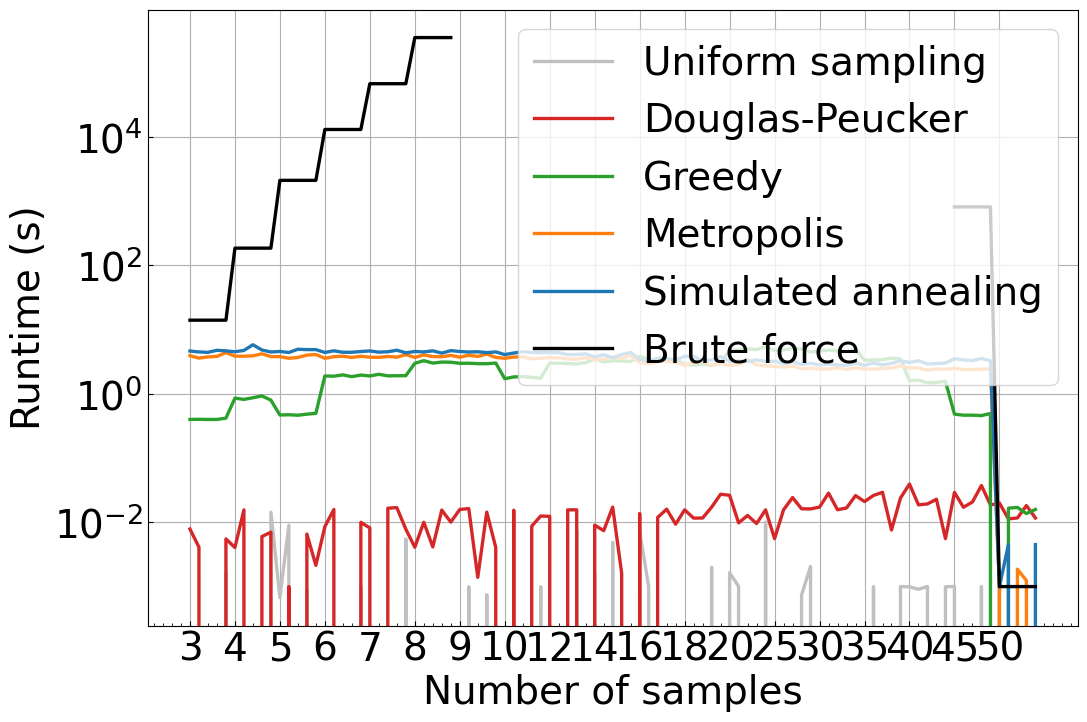

In [12]:
colours = ["silver", "tab:red", "tab:green", "tab:orange", "tab:blue", "black"]

fig, axs = plt.subplots(1, 1, figsize= (12, 8))

for method, runtime, colour in zip(runtimes.keys(), runtimes.values(), colours):
    axs.plot(runtime, label= method, color= colour)

xticks = np.arange(len(reduced_points), dtype= int)[::repetitions]
axs.set(yscale= "log", ylabel= "Runtime (s)", xlabel= "Number of samples", xticks= xticks, xticklabels= reduced_points[xticks])
axs.grid()
plt.legend()
plt.show()

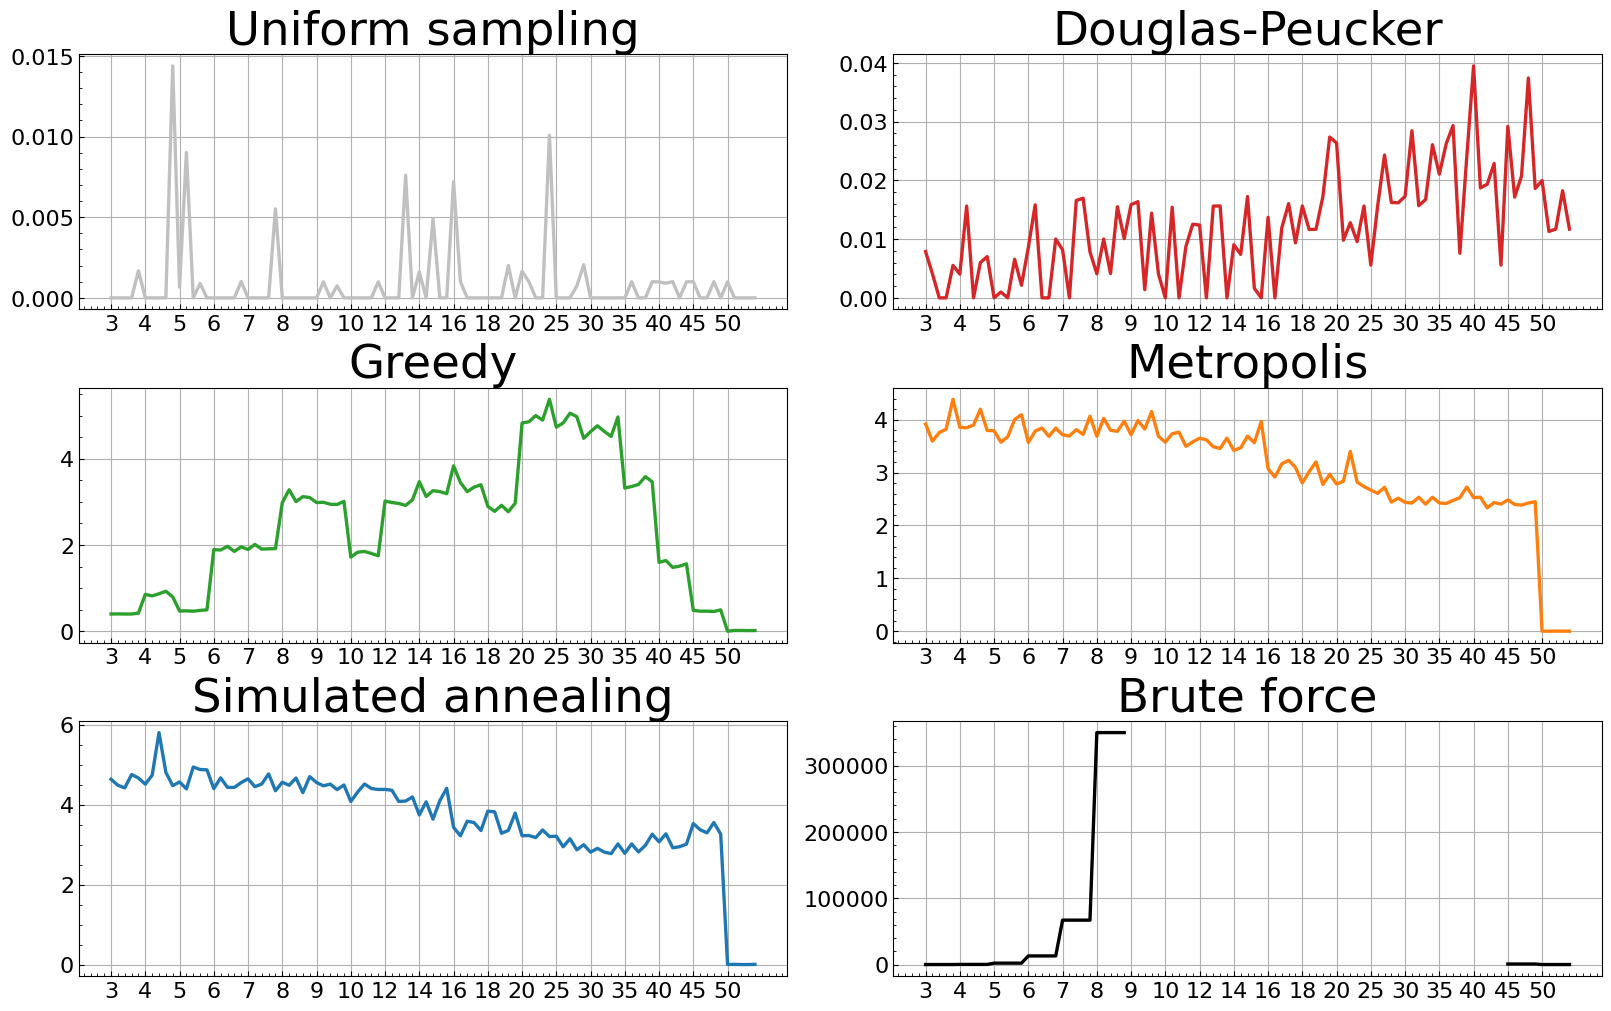

In [13]:
colours = ["silver", "tab:red", "tab:green", "tab:orange", "tab:blue", "black"]

fig, axs = plt.subplots(3, 2, figsize= (16, 10), layout= "constrained")
axs = np.ravel(axs)

xticks = np.arange(len(reduced_points), dtype= int)[::repetitions]

for ax, method, runtime, colour in zip(axs, runtimes.keys(), runtimes.values(), colours):
    ax.plot(runtime, label= method, color= colour)
    ax.set(xticks= xticks, xticklabels= reduced_points[xticks], title= method)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.grid()

plt.show()

In [14]:
mean_score, median_score, std_score, max_score, min_score, best_configurations = {}, {}, {}, {}, {}, {}
for method, best_score in best_scores.items():
    if len(best_score) > 0:
        reshaped_best_scores = np.reshape(best_score, (len(unique_reduced_points), repetitions))
        mean_score[method] = np.mean(reshaped_best_scores, axis= 1)
        median_score[method] = np.median(reshaped_best_scores, axis= 1)
        std_score[method] = np.std(reshaped_best_scores, axis= 1)
        max_score[method] = np.max(reshaped_best_scores, axis= 1)
        min_score[method] = np.min(reshaped_best_scores, axis= 1)

        best_configurations[method] = [configurations[method][best_idx + n*repetitions] for n, best_idx in enumerate(np.argmin(reshaped_best_scores, axis= 1))]

        reshaped_runtimes = np.reshape(runtimes[method], (-1, repetitions))
        median_runtimes[method] = np.median(reshaped_runtimes, axis= 1)
        mean_runtimes[method] = np.mean(reshaped_runtimes, axis= 1)


In [15]:
np.sort(best_configurations["Greedy"][-1])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

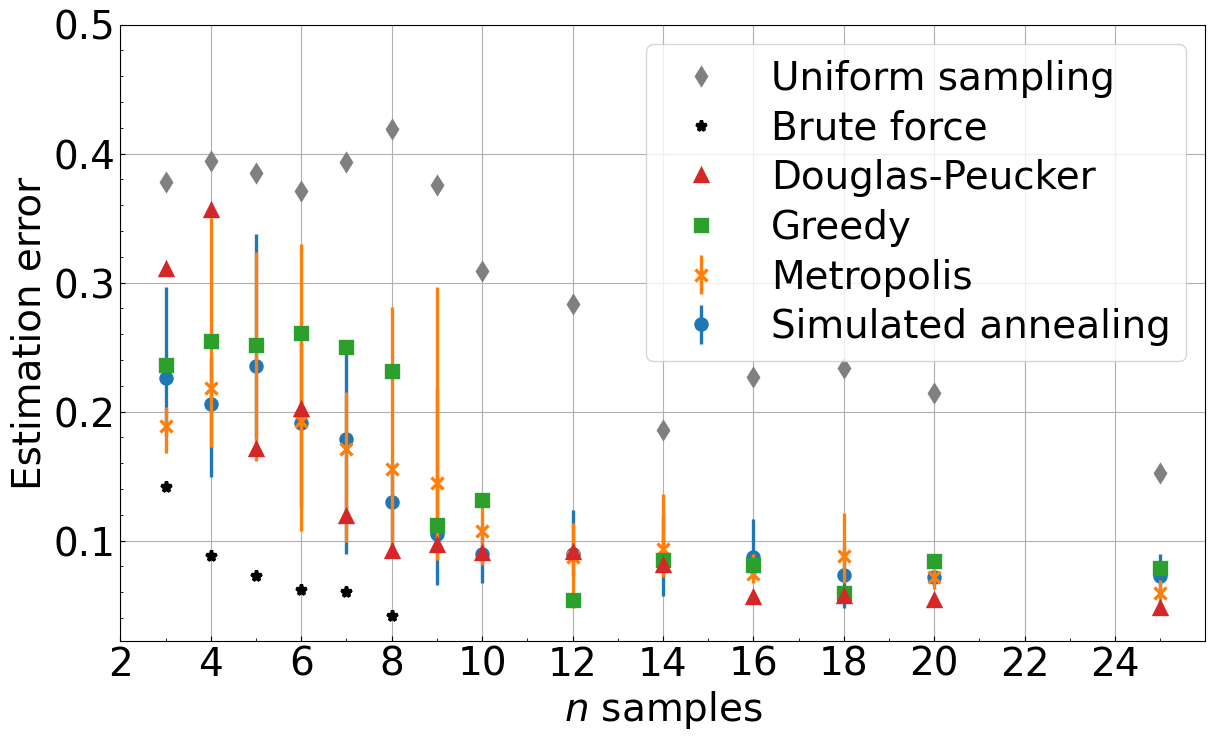

In [22]:
markers= ["d", "*", "^", "s", "x", "o"]
colours = ["gray", "black", "tab:red", "tab:green", "tab:orange", "tab:blue"]
zorders = [4.5, 4, 3.5, 3, 2.5, 2.0]

fig, axs = plt.subplots(figsize= (14,8))

handles = []
labels = []
for method, marker, colour, zorder in zip(["Uniform sampling", "Brute force", "Douglas-Peucker", "Greedy", "Metropolis", "Simulated annealing"], markers, colours, zorders):
        ebar = axs.errorbar(unique_reduced_points, mean_score[method],
                     yerr= (np.abs(mean_score[method] -min_score[method]), np.abs(max_score[method] -mean_score[method])), # can contain negative values due to floating point errors
                     linestyle= "None", marker= marker, markersize= 8, color= colour, label= method, zorder= zorder)
        
        if method in ["Simulated annealing", "Metropolis"]:
                handles.append(ebar)
        else:
                handles.append(
                mpllines.Line2D(
                        [], [], marker=marker, color='w', markerfacecolor=colour,
                        markeredgecolor=colour, markersize=8, linestyle='None', label=method
                )
                )
        labels.append(method)

axs.set(xlabel= "$n$ samples",
        ylabel= r"Estimation error",
        xticks= np.arange(2, 26, 2),
        xlim= (2, 26),
        ylim= (None, 0.5))

minor_locator = ticker.AutoMinorLocator(2)
axs.xaxis.set_minor_locator(minor_locator)

axs.grid(True)

axs.legend(handles, labels, labelspacing= 0.3)
fig.savefig("./graphs/error2samples31.png", bbox_inches= "tight")
plt.show()

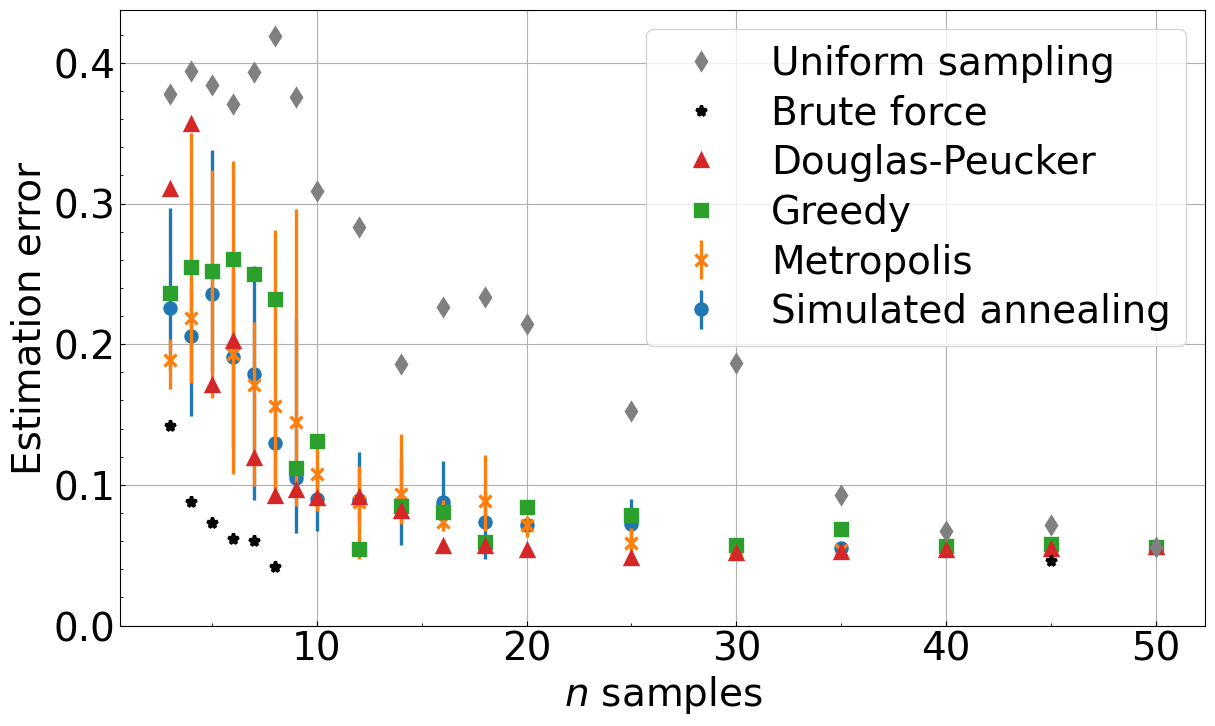

In [20]:
markers= ["d", "*", "^", "s", "x", "o"]
colours = ["gray", "black", "tab:red", "tab:green", "tab:orange", "tab:blue"]
zorders = [4.5, 4, 3.5, 3, 2.5, 2.0]

fig, axs = plt.subplots(figsize= (14,8))

handles = []
labels = []
for method, marker, colour, zorder in zip(["Uniform sampling", "Brute force", "Douglas-Peucker", "Greedy", "Metropolis", "Simulated annealing"], markers, colours, zorders):
        ebar = axs.errorbar(unique_reduced_points, mean_score[method],
                     yerr= (np.abs(mean_score[method] -min_score[method]), np.abs(max_score[method] -mean_score[method])), # can contain negative values due to floating point errors
                     linestyle= "None", marker= marker, markersize= 8, color= colour, label= method, zorder= zorder)
        
        if method in ["Simulated annealing", "Metropolis"]:
                handles.append(ebar)
        else:
                handles.append(
                mpllines.Line2D(
                        [], [], marker=marker, color='w', markerfacecolor=colour,
                        markeredgecolor=colour, markersize=8, linestyle='None', label=method
                )
                )
        labels.append(method)

axs.set(xlabel= "$n$ samples",
        ylabel= r"Estimation error",
        ylim= (0, None))

minor_locator = ticker.AutoMinorLocator(2)
axs.xaxis.set_minor_locator(minor_locator)

axs.grid(True)

axs.legend(handles, labels, labelspacing= 0.3)
fig.savefig("./graphs/error2samples31_long.png", bbox_inches= "tight")
plt.show()

In [18]:
configurations["Douglas-Peucker"][0]

array([25, 23, 41])